In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

In [2]:
# Đọc dữ liệu từ file
df = pd.read_csv("dataset.csv")
# Chuyển cột 'date' thành định dạng thời gian
df['date'] = pd.to_datetime(df['date'])
# Sắp xếp theo thời gian
df = df.sort_values('date')
# Lấy các cột cần thiết
features = ['PM2.5', 'PM10', 'O3', 'NO2', 'SO2', 'CO', 'AQI']
df = df[features]
# Loại bỏ dòng có giá trị thiếu
df = df.dropna()

In [3]:
# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df)
# Tách đặc trưng và nhãn
X_all = scaled[:, :-1]  # PM2.5 đến CO
y_all = scaled[:, -1]   # AQI
# Tạo chuỗi thời gian
def create_sequences(X, y, time_steps):
    Xs, ys = [], []
    for i in range(time_steps, len(X)):
        Xs.append(X[i-time_steps:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)
time_steps = 24  # 24 giờ gần nhất
X, y = create_sequences(X_all, y_all, time_steps)
# Chia tập train/test (80/20)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [4]:
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),  # Cấu trúc đầu vào chuẩn
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 24, 64)              │          18,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,625 (119.63 KB)

 Trainable params: 30,625 (119.63 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.0656 - val_loss: 0.0270
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0293 - val_loss: 0.0139
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0257 - val_loss: 0.0128
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0231 - val_loss: 0.0127
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0239 - val_loss: 0.0127
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0224 - val_loss: 0.0125
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0218 - val_loss: 0.0128
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0191 - val_loss: 0.0128
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0208 - val_loss: 0.0122
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0171 - val_loss: 0.0120
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0173 - val_loss: 0.0114
Epoch 12/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0

In [6]:
# Dự đoán
y_pred = model.predict(X_test)
# Lấy min/max của AQI để đảo ngược chuẩn hóa
aqi_min = scaler.data_min_[-1]
aqi_max = scaler.data_max_[-1]
# Khôi phục giá trị AQI thật
y_test_actual = y_test * (aqi_max - aqi_min) + aqi_min
y_pred_actual = y_pred * (aqi_max - aqi_min) + aqi_min
# Đánh giá
mae = mean_absolute_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
r2 = r2_score(y_test_actual, y_pred_actual)
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.2f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
MAE:  18.96
RMSE: 27.47
R²:   0.45


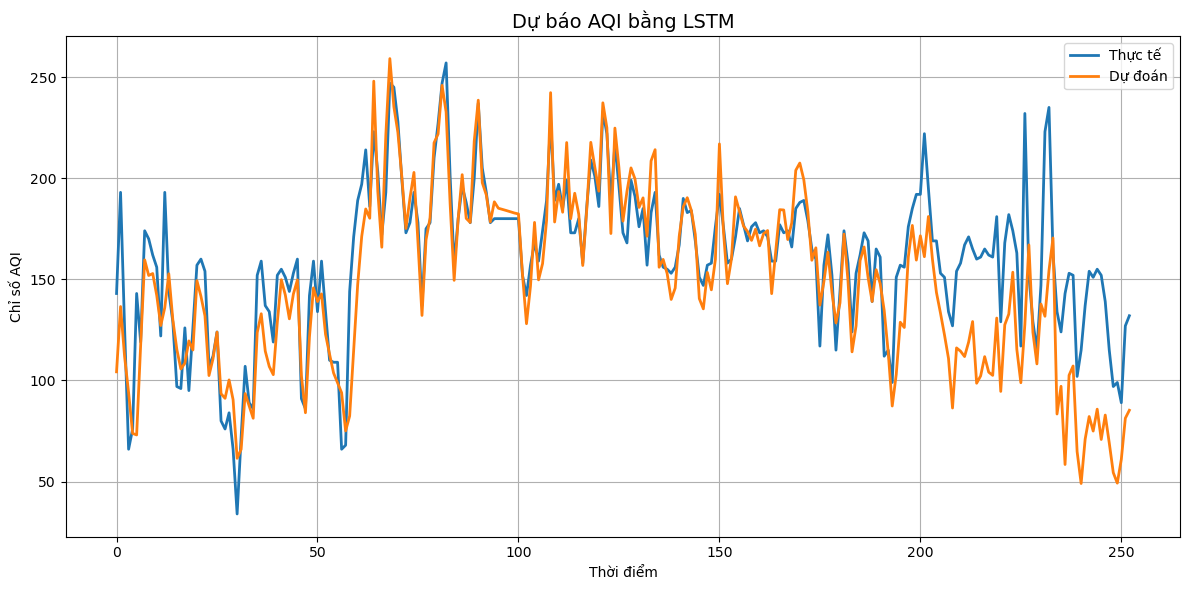

In [7]:
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label='Thực tế', linewidth=2)
plt.plot(y_pred_actual, label='Dự đoán', linewidth=2)
plt.title("Dự báo AQI bằng LSTM", fontsize=14)
plt.xlabel("Thời điểm")
plt.ylabel("Chỉ số AQI")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

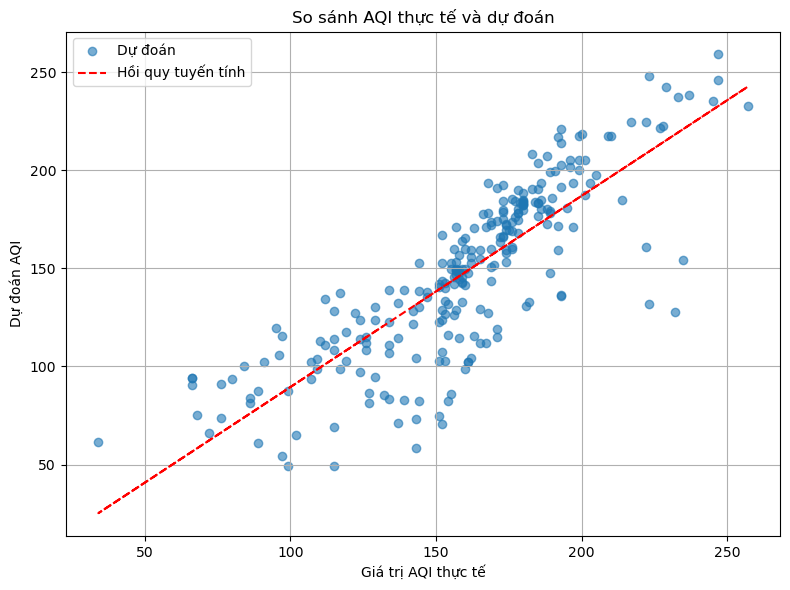

In [9]:
# Định hình lại dữ liệu
y_true = y_test_actual.reshape(-1, 1)
y_pred_flat = y_pred_actual.reshape(-1, 1)

# Hồi quy tuyến tính
reg = LinearRegression()
reg.fit(y_true, y_pred_flat)
line = reg.predict(y_true)

# Vẽ biểu đồ phân tán
plt.figure(figsize=(8,6))
plt.scatter(y_true, y_pred_flat, alpha=0.6, label='Dự đoán')
plt.plot(y_true, line, color='red', linestyle='--', label='Hồi quy tuyến tính')
plt.xlabel('Giá trị AQI thực tế')
plt.ylabel('Dự đoán AQI')
plt.title('So sánh AQI thực tế và dự đoán')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()